## **Proyecto: Detección de Cambios en Interfaces Web para RPA usando IA**

## **3. Feature Engineering Avanzado**
Un Feature Engineering avanzado, pero aplicado a nuestro dataset YOLO (imágenes + labestxt)

Debido a que nuestro dataset no es Tabular (columnas númericas, filas, categorías, etc...) hay que adaptar el análisis al dominio de Visión por computadora.

### **3.1 Creación de Variables Derivadas**
**Variables de interacción:**
- A partir de los labels (x, y, w, h), puedes generar interacciones como:
  - Área del bounding box: area = w * h.
  - Relación de aspecto: aspect_ratio = w / h.
  - Distancia al centro de la imagen: center_dist = sqrt((x-0.5)^2 + (y-0.5)^2).

**Transformaciones matemáticas:**
- log(area) para reducir sesgo si hay objetos muy grandes vs pequeños.
- sqrt(area) para estabilizar varianza.

**Binning y discretización:**
- Categorizar tamaños de objetos:
  - pequeño, mediano, grande según el área.
- Agregaciones temporales (si aplica):
  - Si tus imágenes provienen de video, puedes extraer estadísticas por frame (conteo de objetos por segundo, evolución del área promedio, etc.).


##**3.2 Encoding de Variables Categóricas**

- En YOLO, las categorías son las clases (class_id en los .txt).
- **Label Encoding:** ya está implícito (0, 1, 2, ...) y se define en el archivo .yaml.
- **One-Hot Encoding:** se puede transformar las clases en vectores binarios para análisis estadístico o ML tabular.
- **Target Encoding / Frequency Encoding:** se puede calcular cuántas veces aparece cada clase y usar esa frecuencia como feature (ej. objetos raros vs comunes).
- **Binary Encoding:** útil si se tiene muchísimas clases (no tan común en YOLO con pocos labels y donde los labels ya están codificados en el archivo dataset.yaml).



##**3.3 Transformaciones de Variables Numéricas**
Sobre x, y, w, h, area, aspect_ratio:
- **Normalización (Min-Max Scaling):**
  
  Ya están entre [0,1], pero se podría escalar features derivados como area o center_dist.
- **Estandarización (Z-score):**
  
  Centrar variables ((x - μ) / σ) para usarlas en modelos tabulares.
- **Robust Scaling:**
  
  se podría aplicar si hay outliers en tamaños (objetos muy grandes).
- **Quantile Transformation:**
  
  Para convertir distribuciones sesgadas en distribuciones uniformes o normales.

##**3.4 Feature Selection**

- **Métodos basados en modelos:**
  - RandomForest.feature_importances_ para saber qué variables derivadas son más relevantes.
  - LASSO para eliminar variables irrelevantes.
  - RFE (Recursive Feature Elimination) para quedarte con el mejor subconjunto.

##**3.5 Extracción de Características Específicas del Dominio**
Como se trabaja con imágenes:

- **Características de imágenes:**

  - **SIFT (Scale-Invariant Feature Transform):** detecta puntos clave y descriptores de objetos.
  - **HOG (Histogram of Oriented Gradients):** útil para detectar bordes y formas.
  - **Color histograms:** distribuciones de color por objeto o por imagen.
  - **CNN embeddings:** La red Convolucional que vamos a utilizar es YOLOV8,  por lo tanto produce embeddings como parte de su proceso. Es un detector de objetos y utiliza estos embeddings internamente para realizar sus predicciones de detección y clasificación. Aunque su fuerte es la detección.

Se consideraron distintas técnicas clásicas de visión por computadora, tales como HOG (Histogram of Oriented Gradients) y SIFT (Scale-Invariant Feature Transform), las cuales han sido ampliamente utilizadas para describir bordes, formas y puntos clave en imágenes.

No obstante, en este proyecto no se implementaron dichas técnicas, ya que el modelo seleccionado, YOLOv8, se basa en una arquitectura de redes neuronales convolucionales (CNNs) que, de manera inherente, realiza la extracción de descriptores robustos durante su proceso de entrenamiento.

En particular, YOLO genera embeddings internos que permiten representar de forma eficiente las características relevantes de los objetos para su detección y clasificación. Por este motivo, el análisis de características adicionales como HOG o SIFT resultaba redundante y se optó por centrar la ingeniería de características en variables derivadas directamente de las etiquetas de anotación (coordenadas, área, proporciones y distancias relativas), las cuales permiten enriquecer el análisis exploratorio de datos (EDA) sin interferir en la naturaleza end-to-end del modelo de detección.


In [3]:
# 1. Montar Google Drive para usar el dataset desde ahi
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class FeatureEngineer:
    def __init__(self, repo_path):
        self.repo_path = repo_path
        self.df = None
        self.scalers = {}
    #3.1 Creación de Variables Derivadas
    #Extracción de características a partir de los labels YOLO (x, y, w, h, area, aspect_ratio, center_dist).
    def _extract_features(self):
        """Extrae features derivados de los labels YOLO"""
        features = []

        for subset in ["train", "val", "test"]:
            label_dir = os.path.join(self.repo_path, subset, "labels")
            if not os.path.exists(label_dir):
                continue

            for txt in glob.glob(os.path.join(label_dir, "*.txt")):
                with open(txt, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            continue

                        cls, x, y, w, h = map(float, parts)
                        area = w * h
                        aspect_ratio = w / h if h > 0 else 0
                        center_dist = np.sqrt((x - 0.5) ** 2 + (y - 0.5) ** 2)

                        features.append({
                            "subset": subset,
                            "class": int(cls),
                            "x": x,
                            "y": y,
                            "w": w,
                            "h": h,
                            "area": area,
                            "aspect_ratio": aspect_ratio,
                            "center_dist": center_dist
                        })

        self.df = pd.DataFrame(features)
        return self

    #3.2 Encoding de Variables Categóricas
    #Codifica categorías (class) en distintos formatos (One-Hot, Label, Frequency).
    def encode_categories(self, method="onehot"):
        if self.df is None:
            raise ValueError("Primero ejecuta _extract_features()")

        if method == "onehot":
            self.df = pd.get_dummies(self.df, columns=["class"], prefix="cls")
        elif method == "frequency":
            freq = self.df["class"].value_counts().to_dict()
            self.df["class_freq"] = self.df["class"].map(freq)
        elif method == "label":
            self.df["class"] = self.df["class"].astype("category").cat.codes
        return self

    ##3.3 Transformaciones de Variables Numéricas
    #Escala variables numéricas con Min-Max o Z-score.
    def transform_numeric(self, cols, method="minmax"):
        if self.df is None:
            raise ValueError("Primero ejecuta _extract_features()")

        if method == "minmax":
            scaler = MinMaxScaler()
        elif method == "zscore":
            scaler = StandardScaler()
        else:
            raise ValueError("Método no soportado")

        self.df[[c + "_" + method for c in cols]] = scaler.fit_transform(self.df[cols])
        self.scalers[method] = scaler
        return self

    ##3.4 Feature Selection
    #Selecciona features relevantes con Random Forest.
    def feature_selection_rf(self, target_col="class", n_features=5):
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.feature_selection import SelectFromModel

        X = self.df.drop(columns=[target_col, "subset"], errors="ignore")
        y = self.df[target_col]

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        selector = SelectFromModel(rf, max_features=n_features, prefit=True)
        selected_features = X.columns[selector.get_support()].tolist()
        return selected_features

    def get_features(self):
        return self.df



In [5]:
repo_path = "/content/drive/MyDrive/MIA/Dataset"

fe = FeatureEngineer(repo_path)
fe._extract_features() \
  .encode_categories(method="frequency") \
  .transform_numeric(cols=["area", "aspect_ratio", "center_dist"], method="zscore")

df_features = fe.get_features()
print(df_features.head())

# Selección de features con Random Forest
selected = fe.feature_selection_rf(target_col="class", n_features=5)
print("Features seleccionados:", selected)

  subset  class         x         y         w         h      area  \
0  train      0  0.018229  0.058980  0.020833  0.015940  0.000332   
1  train      2  0.093929  0.021785  0.117025  0.026567  0.003109   
2  train      1  0.042696  0.051010  0.018726  0.027630  0.000517   
3  train      1  0.042696  0.051010  0.016642  0.023379  0.000389   
4  train      1  0.042696  0.051010  0.017684  0.023379  0.000413   

   aspect_ratio  center_dist  class_freq  area_zscore  aspect_ratio_zscore  \
0      1.306944     0.653148       19368    -0.209376            -0.156578   
1      4.404811     0.627362         452    -0.120759             0.211517   
2      0.677722     0.640874        6605    -0.203463            -0.231344   
3      0.711835     0.640874        6605    -0.207557            -0.227291   
4      0.756389     0.640874        6605    -0.206780            -0.221997   

   center_dist_zscore  
0            1.734545  
1            1.565880  
2            1.654261  
3            1.65426

Ya que en el paso anterior definimos un FeatureEngineer que te devuelve un DataFrame con features derivadas (ancho, alto, área, posición de objetos, clase, etc.), ahora podemos construir un pipeline de visualización/análisis exploratorio directamente sobre ese dataset transformado.

In [6]:
# ======================================
# PIPELINE DE ANÁLISIS EXPLORATORIO
# PARA FEATURES EXTRAÍDOS DE YOLO
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_yolo_features(df):
    """
    Recibe el DataFrame generado por FeatureEngineer
    y produce gráficos relevantes para analizar el dataset YOLO.
    """

    # 1) Distribución de clases
    if "class" in df.columns:
        plt.figure(figsize=(10,6))
        sns.countplot(x="class", data=df, order=df["class"].value_counts().index)
        plt.title("Distribución de Clases")
        plt.xlabel("Clase")
        plt.ylabel("Frecuencia")
        plt.show()

    # 2) Histogramas de ancho y alto
    if "w" in df.columns and "h" in df.columns:
        plt.figure(figsize=(10,6))
        sns.histplot(df["w"], kde=True, color="blue", label="Width")
        sns.histplot(df["h"], kde=True, color="red", label="Height")
        plt.legend()
        plt.title("Distribución de Ancho y Alto (normalizados)")
        plt.show()

    # 3) Distribución del área
    if "area" in df.columns:
        plt.figure(figsize=(10,6))
        sns.histplot(df["area"], bins=30, kde=True, color="green")
        plt.title("Distribución del Área de Bounding Boxes")
        plt.xlabel("Área (w*h)")
        plt.show()

    # 4) Aspect Ratio
    if "aspect_ratio" in df.columns:
        plt.figure(figsize=(10,6))
        sns.histplot(df["aspect_ratio"], bins=30, kde=True, color="orange")
        plt.title("Distribución del Aspect Ratio (w/h)")
        plt.show()

    # 5) Heatmap de posiciones de centros
    if "x" in df.columns and "y" in df.columns:
        plt.figure(figsize=(8,8))
        sns.kdeplot(x=df["x"], y=df["y"], fill=True, cmap="Reds", thresh=0.05)
        plt.title("Heatmap de posiciones de objetos (x,y)")
        plt.xlabel("x_center (normalizado)")
        plt.ylabel("y_center (normalizado)")
        plt.show()

    # 6) Objetos por subconjunto (train, val, test)
    if "subset" in df.columns:
        plt.figure(figsize=(10,6))
        sns.countplot(x="subset", data=df)
        plt.title("Número de Objetos por Subconjunto")
        plt.xlabel("Subset")
        plt.ylabel("Cantidad")
        plt.show()

    # 7) Correlaciones numéricas
    plt.figure(figsize=(10,8))
    corr = df.select_dtypes(include="number").corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Matriz de Correlaciones")
    plt.show()

def analyze_yolo_features_by_subset(df):
    #Recibe el DataFrame generado por FeatureEngineer
    #y produce gráficos relevantes para cada subset (train, val, test).

    subsets = df["subset"].unique() if "subset" in df.columns else ["all"]

    for subset in subsets:
        print(f"\n\n===================================")
        print(f"🔎 Análisis para Subconjunto: {subset}")
        print(f"=======================================")

        # Filtramos si existe subset
        if "subset" in df.columns:
            df_sub = df[df["subset"] == subset]
        else:
            df_sub = df.copy()

        analyze_yolo_features(df_sub)




🔎 Análisis para Subconjunto: train


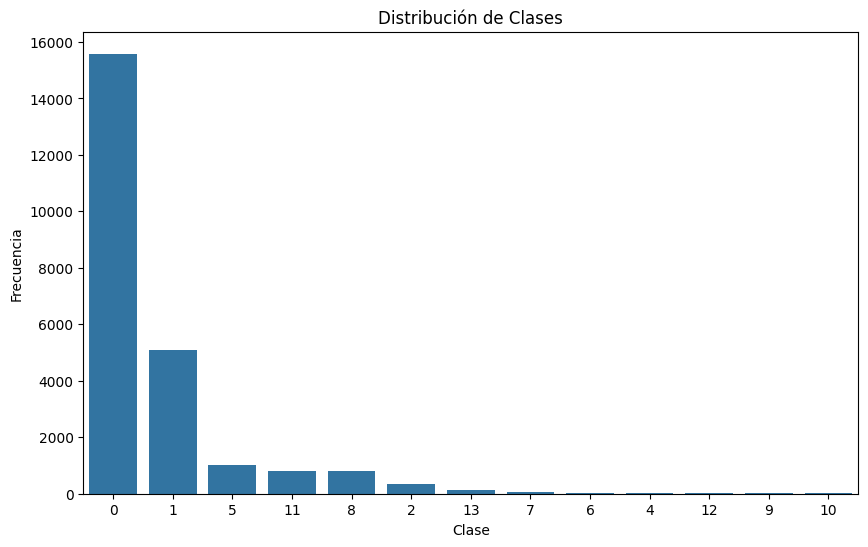

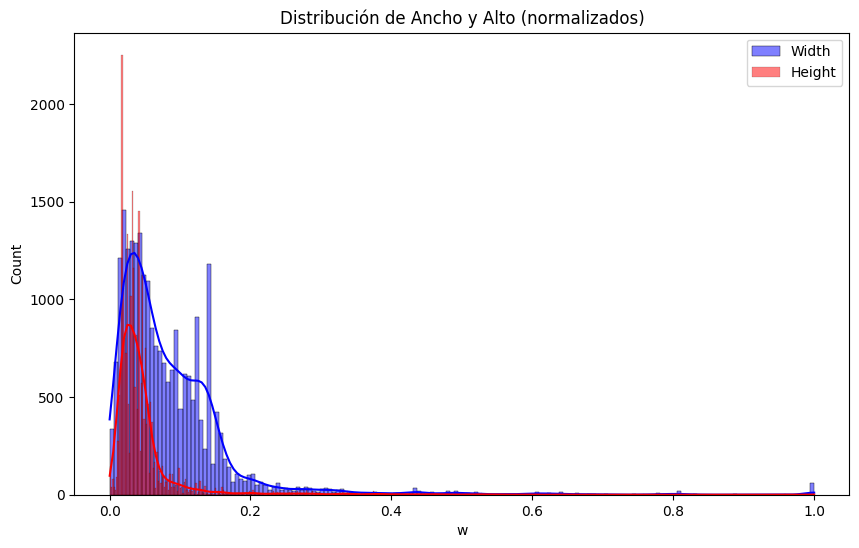

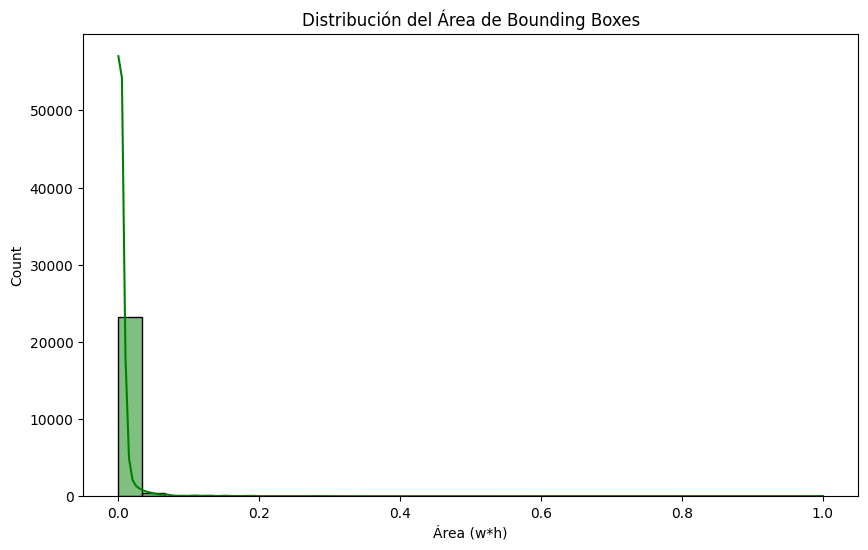

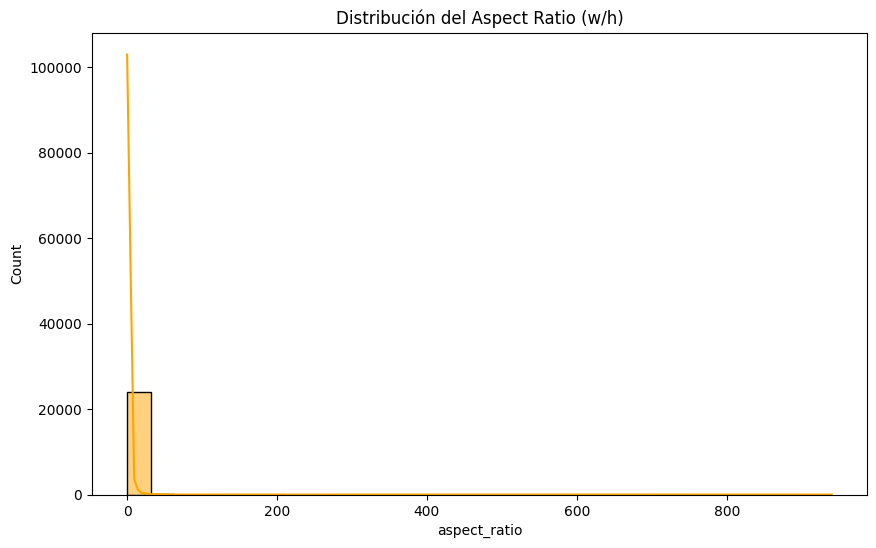

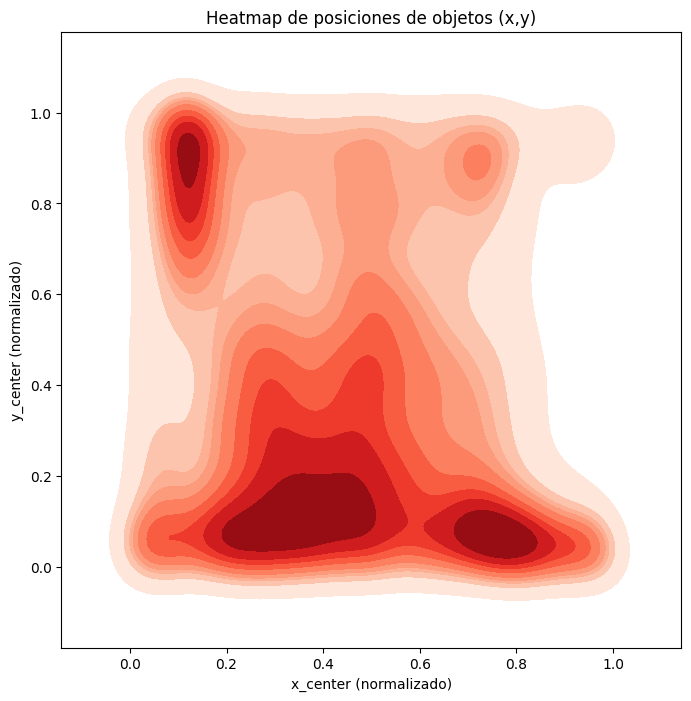

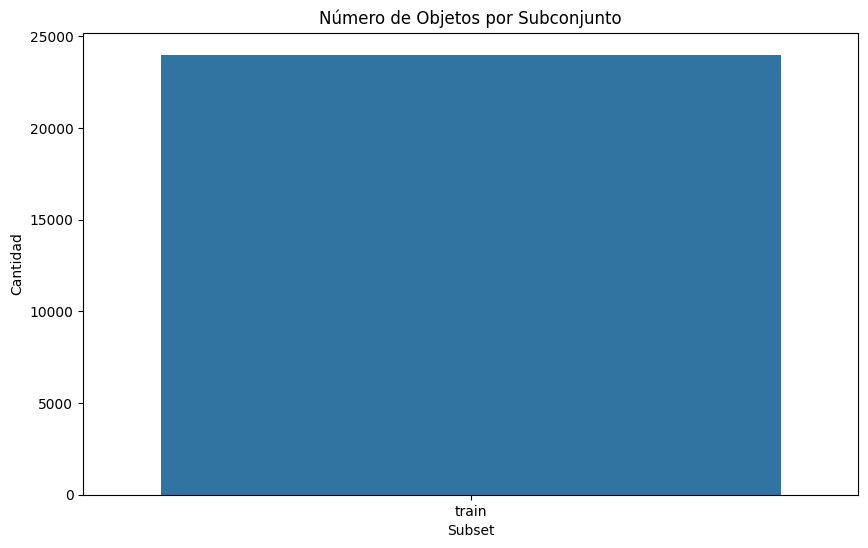

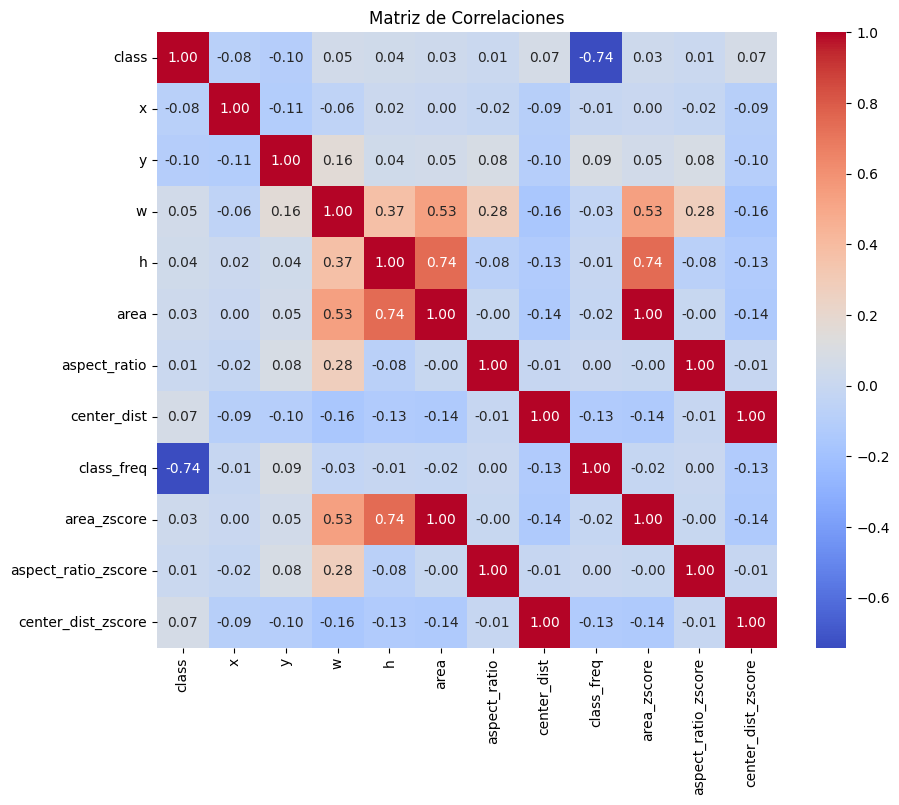



🔎 Análisis para Subconjunto: val


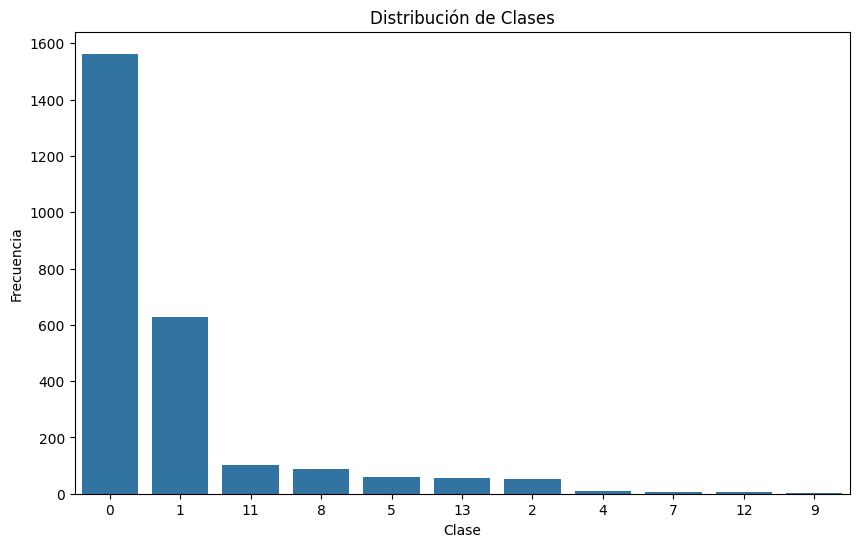

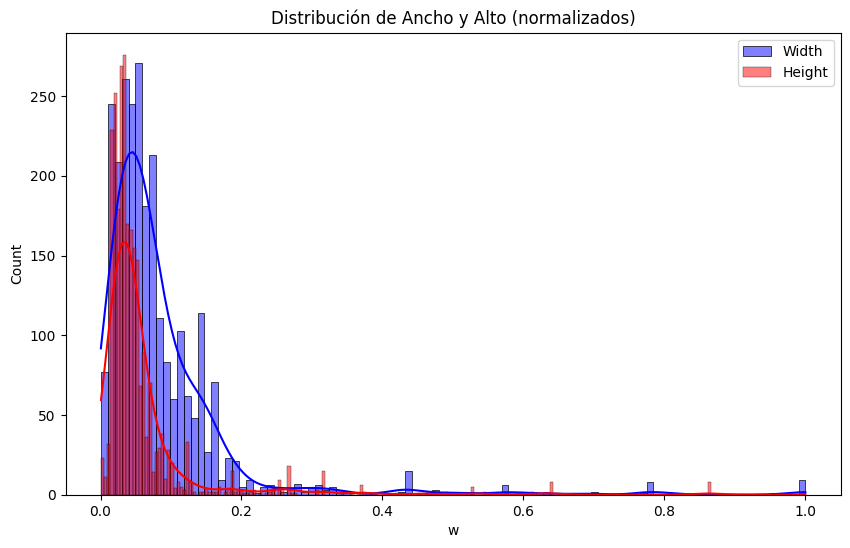

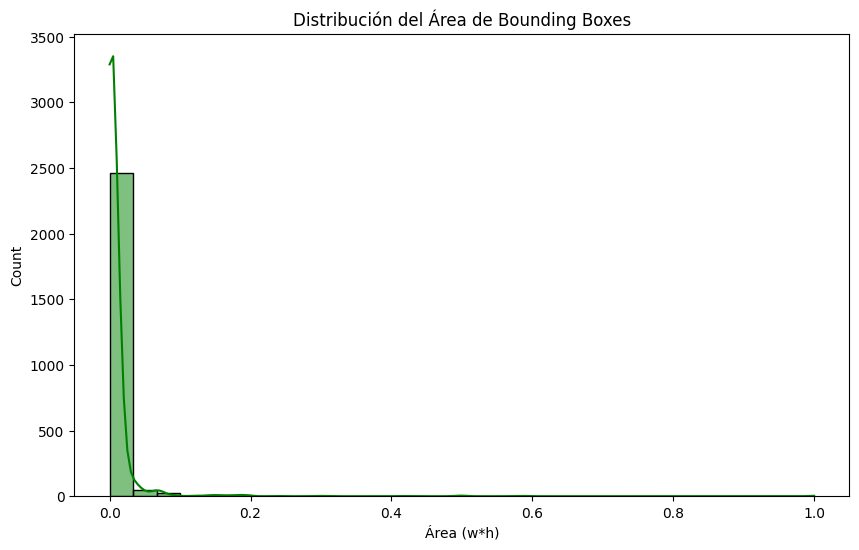

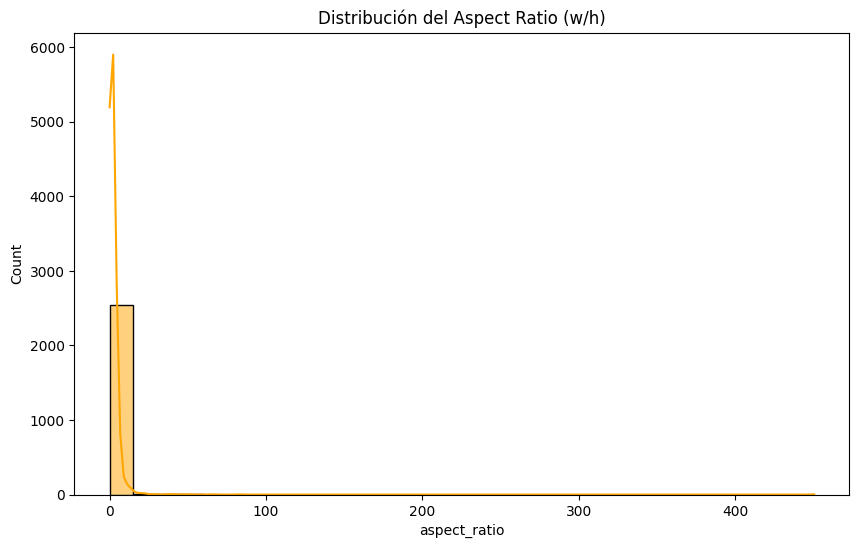

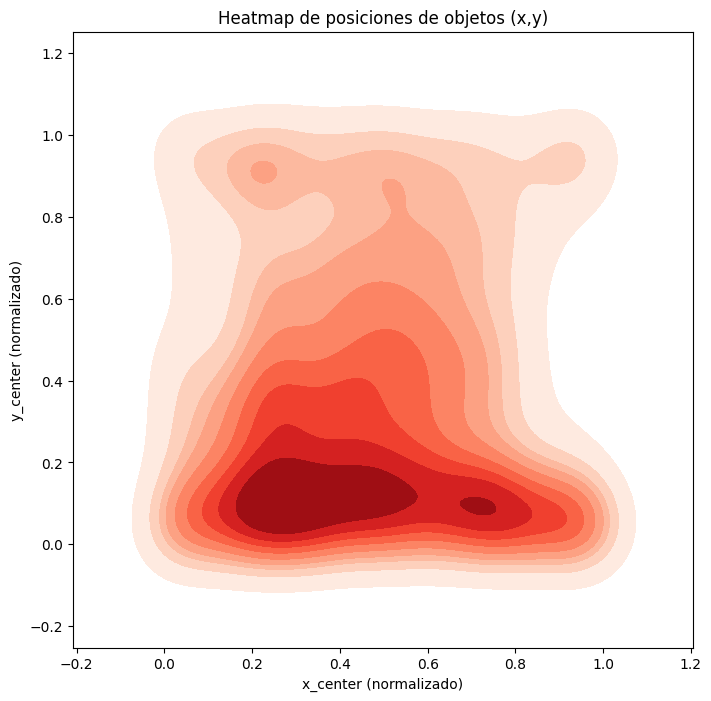

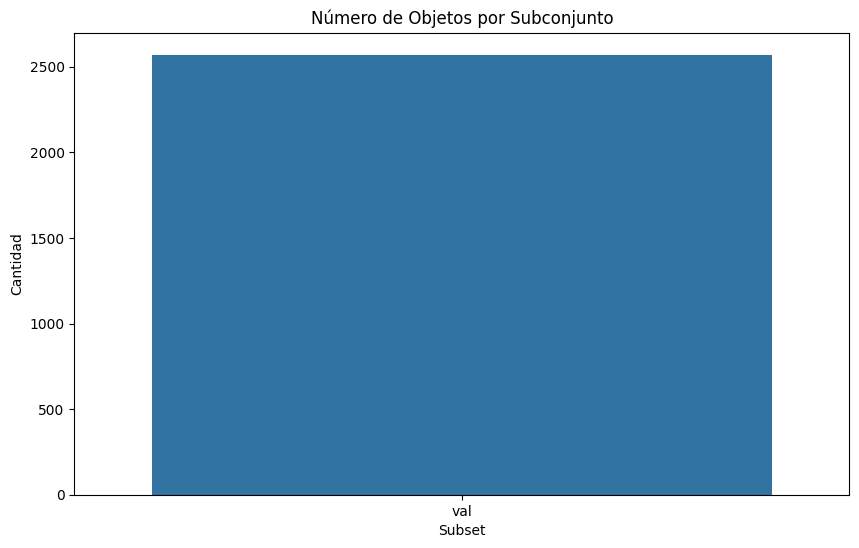

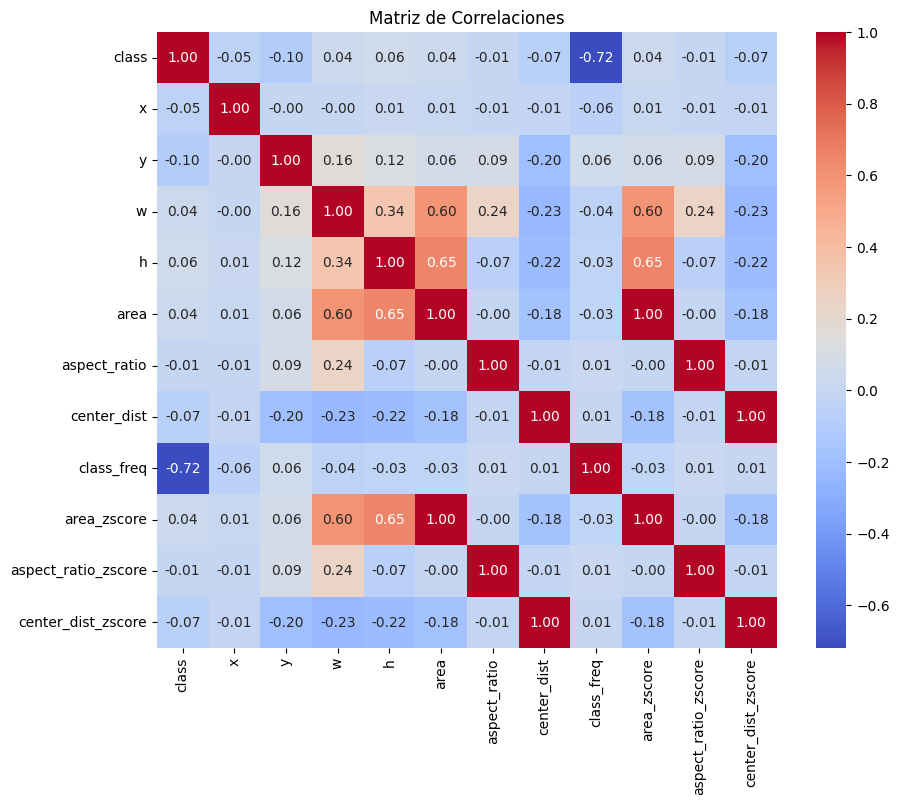



🔎 Análisis para Subconjunto: test


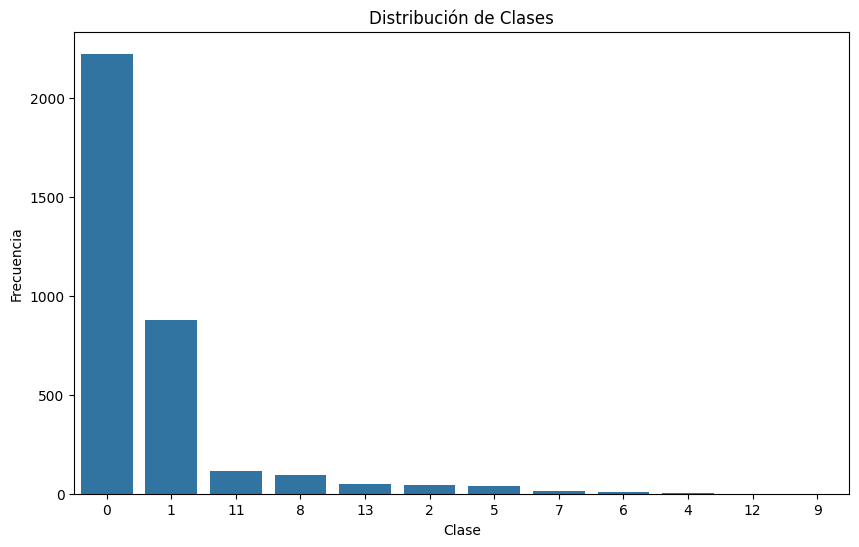

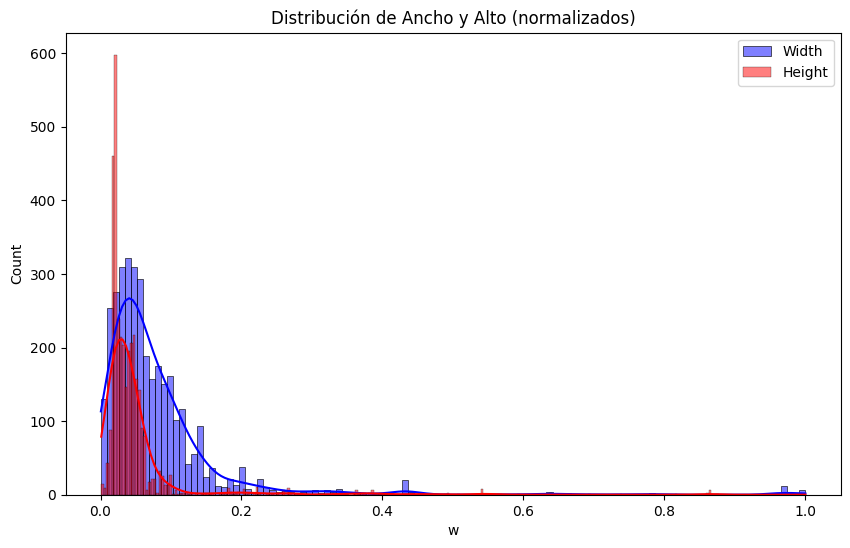

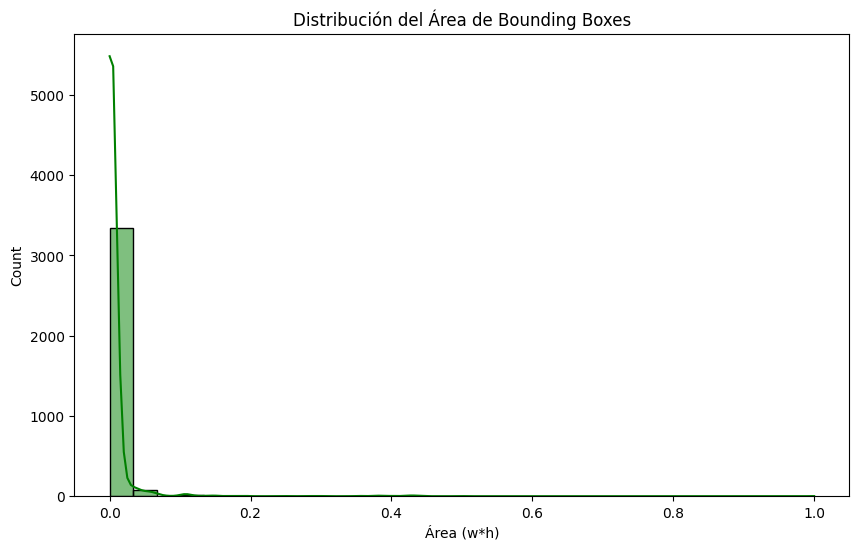

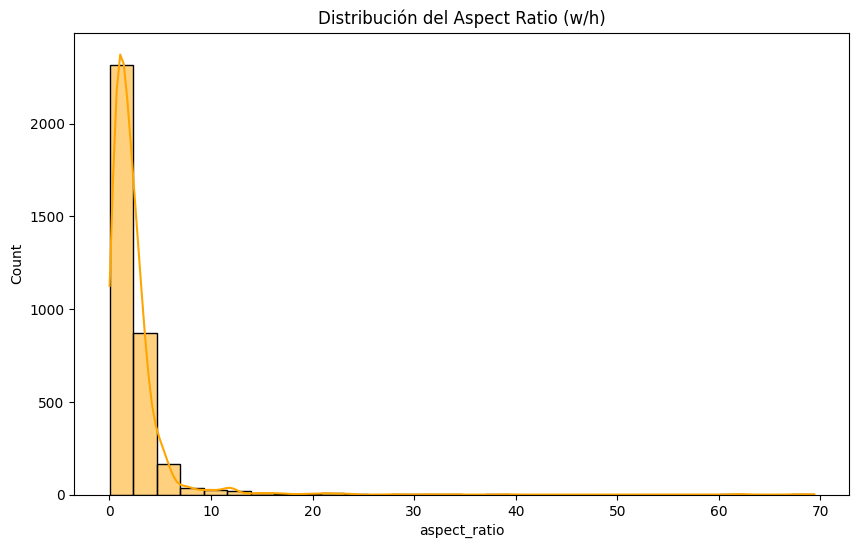

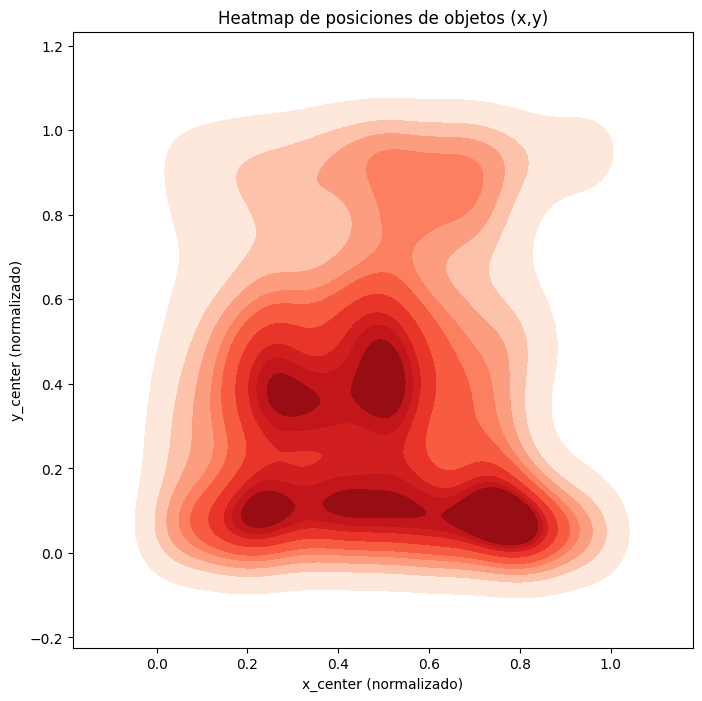

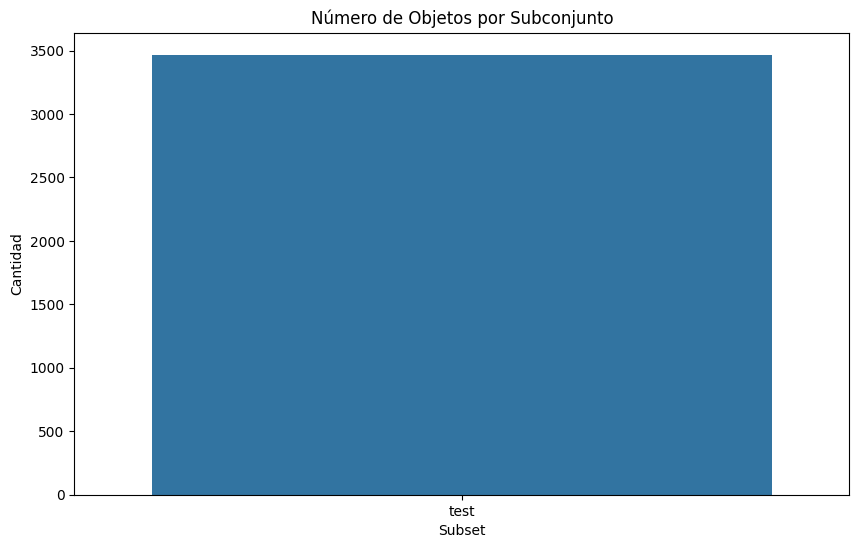

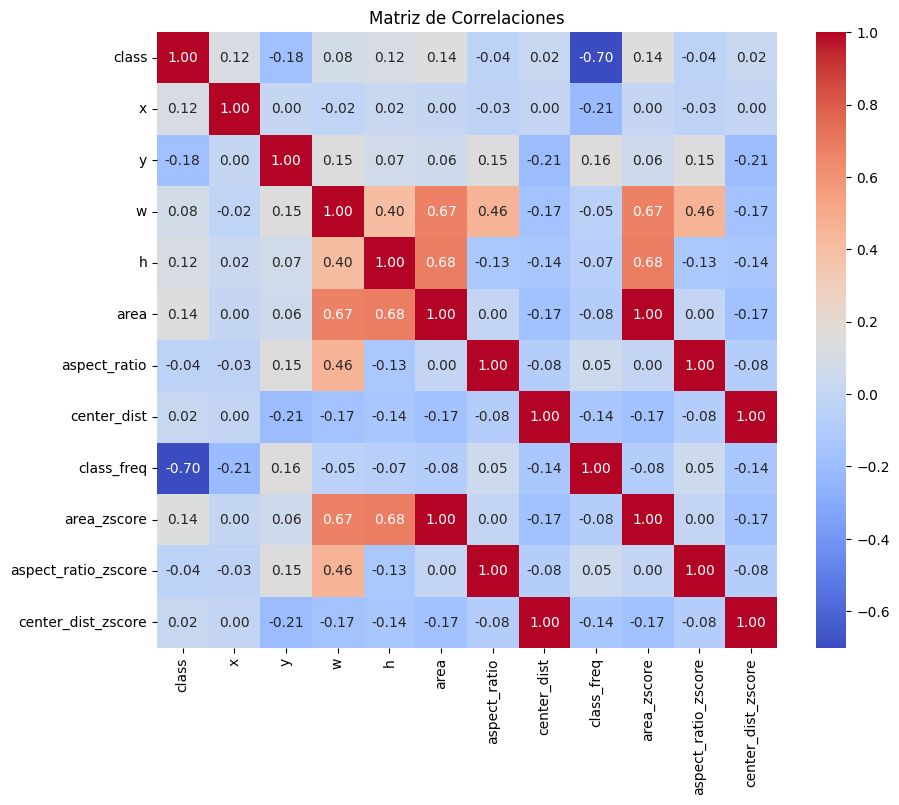

In [8]:
# ================================
# Explorar DataFrame df_features
#analyze_yolo_features(df_features)
analyze_yolo_features_by_subset(df_features)